# 🎴 Moroccan Spanish Take2 Game | Q-Learning

## 📦 Installation & Imports

In [1]:
!pip install gymnasium numpy matplotlib --quiet
print("✅ Packages installed")

✅ Packages installed


In [2]:
import numpy as np
import random
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict, Counter
from typing import Tuple, List, Optional, Dict, Any
from enum import IntEnum

np.random.seed(42)
random.seed(42)
print("✅ Imports successful")

✅ Imports successful


## 🃏 Card System

Memory-optimized card representation using `__slots__` for efficiency.

In [3]:
class Suit(IntEnum):
    OROS = 0
    COPAS = 1
    ESPADAS = 2
    BASTOS = 3


class Rank(IntEnum):
    AS = 1
    DOS = 2
    TRES = 3
    CUATRO = 4
    CINCO = 5
    SEIS = 6
    SIETE = 7
    SOTA = 10
    CABALLO = 11
    REY = 12


class Card:
    """Memory-optimized card representation"""
    __slots__ = ['suit', 'rank', '_hash']
    
    def __init__(self, suit: Suit, rank: Rank):
        self.suit = suit
        self.rank = rank
        self._hash = hash((suit, rank))
    
    def __repr__(self):
        return f"{self.rank.value}-{['O','C','E','B'][self.suit]}"
    
    def __eq__(self, other):
        return isinstance(other, Card) and self.suit == other.suit and self.rank == other.rank
    
    def __hash__(self):
        return self._hash

print("✅ Card system defined")

✅ Card system defined


## 🎮 Game Environment

### Observation Space (57 dimensions, all np.int16):
- **[0-9]**: Hand counts (count of each rank in hand)
- **[10-23]**: Table card one-hot (10 ranks + 4 suits)
- **[24-43]**: Legal action mask (20 binary flags) ← EXPANDED to handle large hands
- **[44]**: Opponent hand size
- **[45]**: Is my turn (always 1 from agent perspective)
- **[46]**: Penalty stack

This provides a complete, healthy observation of the game state!

In [4]:
class Hazz2Env(gym.Env):
    """Hazz2 card game environment with comprehensive integer observation space."""
    
    def __init__(self):
        super().__init__()
        
        self.valid_ranks = [1, 2, 3, 4, 5, 6, 7, 10, 11, 12]
        self.rank_to_idx = {r: i for i, r in enumerate(self.valid_ranks)}
        
        self.full_deck = [
            Card(Suit(s), Rank(r)) 
            for s in range(4) 
            for r in self.valid_ranks
        ]
        
        # Integer observation space: 57 dimensions
        # [0-9]: hand_counts (10)
        # [10-23]: table_card (14)
        # [24-43]: legal_actions (20)
        # [44]: opponent_hand_size (1)
        # [45]: is_my_turn (1)
        # [46]: penalty_stack (1)
        self.observation_space = spaces.Box(
            low=0, 
            high=25,  # Max possible value
            shape=(62,), 
            dtype=np.int16
        )
        
        # Action space: up to 20 actions (handles penalty card accumulation)
        self.action_space = spaces.Discrete(25)
        
    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None):
        """Reset environment to initial state"""
        super().reset(seed=seed)
        
        self.deck = self.full_deck.copy()
        random.shuffle(self.deck)
        
        self.agent_hand = [self.deck.pop() for _ in range(4)]
        self.opponent_hand = [self.deck.pop() for _ in range(4)]
        
        # Valid starting card (not AS, DOS, or SIETE)
        first_card = self.deck.pop()
        while first_card.rank in [Rank.AS, Rank.DOS, Rank.SIETE]:
            self.deck.append(first_card)
            random.shuffle(self.deck)
            first_card = self.deck.pop()
        
        self.discard_pile = [first_card]
        self.current_suit = first_card.suit
        self.penalty_stack = 0
        self.skip_opponent = False
        self.game_over = False
        self.winner = None
        self.total_turns = 0
        self.consecutive_draws = 0
        
        return self._get_observation(), {}
    
    def _get_observation(self) -> np.ndarray:
        """Create 57-dimensional integer observation"""
        obs = np.zeros(62, dtype=np.int16)
        
        # [0-9] Hand counts
        for card in self.agent_hand:
            rank_idx = self.rank_to_idx[card.rank]
            obs[rank_idx] += 1
        
        # [10-23] Table card one-hot
        top_card = self.discard_pile[-1]
        rank_idx = self.rank_to_idx[top_card.rank]
        obs[10 + rank_idx] = 1  # Rank
        obs[20 + top_card.suit] = 1  # Suit
        
        # [24-43] Legal action mask (20 actions)
        valid_actions = self.get_valid_actions()
        for action in valid_actions:
            if action < 25:  # Safety check
                obs[24 + action] = 1
        # [49] Opponent hand size
        obs[49] = min(len(self.opponent_hand), 25)
        # [50] Is my turn
        obs[50] = 1
        # [51] Penalty stack
        obs[51] = min(self.penalty_stack, 10)
        # # [44] Opponent hand size
        # obs[44] = min(len(self.opponent_hand), 20)
        
        # # [45] Is my turn
        # obs[45] = 1
        
        # # [46] Penalty stack
        # obs[46] = min(self.penalty_stack, 10)
        
        return obs
    
    def get_valid_actions(self) -> List[int]:
        """Return list of valid action indices"""
        valid = []
        for i, card in enumerate(self.agent_hand):
            if self._is_playable(card):
                valid.append(i)
        valid.append(len(self.agent_hand))  # Draw action
        return valid
    
    def _is_playable(self, card: Card) -> bool:
        """Check if card can be played"""
        top_card = self.discard_pile[-1]
        if self.penalty_stack > 0:
            return card.rank == Rank.DOS
        return (card.rank == top_card.rank or card.suit == self.current_suit)
    
    def _choose_suit_heuristic(self, hand: List[Card]) -> Suit:
        """Choose most common suit in hand"""
        if not hand:
            return Suit.OROS
        suit_counts = Counter(card.suit for card in hand)
        return suit_counts.most_common(1)[0][0]
    
    def _apply_special_effects(self, card: Card, is_agent: bool):
        """Apply special card effects"""
        if card.rank == Rank.DOS:
            self.penalty_stack += 2
            # self.penalty_stack = min(self.penalty_stack + 2, 8)
        elif card.rank == Rank.SIETE:
            hand = self.agent_hand if is_agent else self.opponent_hand
            self.current_suit = self._choose_suit_heuristic(hand)
        elif card.rank == Rank.AS:
            if is_agent:
                self.skip_opponent = True
    
    def _calculate_reward(self, action: int, card_played: Optional[Card], 
                         forced_draw: bool) -> float:
        """Calculate shaped reward"""
        reward = -0.01  # Small step penalty
        
        # if forced_draw:
            # reward -= 0.3
        # elif card_played is not None:
        if card_played is not None:
            # reward += 0.1
            
            # Special card bonuses
            if card_played.rank == Rank.AS:
                reward += 0.25
            elif card_played.rank == Rank.DOS:
                reward += 0.5
            elif card_played.rank == Rank.SIETE:
                reward += 0.25
            
            # Hand size bonuses
            if len(self.agent_hand) <= 2:
                reward += 7
            elif len(self.agent_hand) <= 4:
                reward += 5
        
        # Game outcome
        if self.game_over:
            if self.winner == 0:
                reward += 10.0
                if self.total_turns < 20:
                    reward += 2.0
            elif self.winner == 1:
                reward -= 10.0
        
        return reward
    
    def _reset_deck_if_needed(self):
        """Recycle discard pile if deck exhausted"""
        if len(self.deck) == 0 and len(self.discard_pile) > 1:
            top_card = self.discard_pile.pop()
            self.deck = self.discard_pile.copy()
            random.shuffle(self.deck)
            self.discard_pile = [top_card]
    
    def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, Dict]:
        """Execute one step"""
        if self.game_over:
            return self._get_observation(), 0.0, True, False, {}
        
        self.total_turns += 1
        valid_actions = self.get_valid_actions()
        
        if action not in valid_actions:
            action = len(self.agent_hand)  # Force draw
        
        card_played = None
        forced_draw = False
        
        # Agent turn
        if action < len(self.agent_hand):
            card_played = self.agent_hand.pop(action)
            self.discard_pile.append(card_played)
            self.current_suit = card_played.suit
            self._apply_special_effects(card_played, is_agent=True)
            self.consecutive_draws = 0
            
            if len(self.agent_hand) == 0:
                self.game_over = True
                self.winner = 0
                reward = self._calculate_reward(action, card_played, forced_draw)
                return self._get_observation(), reward, True, False, {'winner': 0}
        else:
            if self.penalty_stack > 0:
                cards_to_draw = self.penalty_stack
                forced_draw = True
                self.penalty_stack = 0
            else:
                cards_to_draw = 1
            
            for _ in range(cards_to_draw):
                self._reset_deck_if_needed()
                if self.deck:
                    self.agent_hand.append(self.deck.pop())
            
            self.consecutive_draws += 1
        
        # Draw loop termination
        if self.consecutive_draws >= 10:
            self.game_over = True
            self.winner = None
            reward = self._calculate_reward(action, card_played, forced_draw)
            return self._get_observation(), reward, True, False, {'winner': None}
        
        # Opponent turn
        if not self.game_over and not self.skip_opponent:
            self._opponent_turn()
        else:
            self.skip_opponent = False
        
        reward = self._calculate_reward(action, card_played, forced_draw)
        return self._get_observation(), reward, self.game_over, False, \
               {'winner': self.winner if self.game_over else None}
    
    def _opponent_turn(self):
        """Simple heuristic opponent"""
        playable = [i for i, card in enumerate(self.opponent_hand) 
                   if self._is_playable(card)]
        
        if playable:
            idx = playable[0]
            card = self.opponent_hand.pop(idx)
            self.discard_pile.append(card)
            self.current_suit = card.suit
            self._apply_special_effects(card, is_agent=False)
            self.consecutive_draws = 0
            
            if len(self.opponent_hand) == 0:
                self.game_over = True
                self.winner = 1
        else:
            if self.penalty_stack > 0:
                cards_to_draw = self.penalty_stack
                self.penalty_stack = 0
            else:
                cards_to_draw = 1
            
            for _ in range(cards_to_draw):
                self._reset_deck_if_needed()
                if self.deck:
                    self.opponent_hand.append(self.deck.pop())

print("✅ Environment defined")

✅ Environment defined


## 🧠 Q-Learning Agent

Tabular Q-learning with:
- Action masking for valid moves only
- Epsilon-greedy exploration
- Adaptive learning
- Expanded Q-table to handle up to 20 actions

In [5]:
class QLearningAgent:
    """Tabular Q-Learning agent with action masking"""
    
    def __init__(
        self,
        alpha: float = 0.1,
        gamma: float = 0.95,
        epsilon_start: float = 1.0,
        epsilon_end: float = 0.05,
        epsilon_decay: float = 0.99995
    ):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        
        # Q-table expanded to 20 actions
        self.q_table = defaultdict(lambda: np.zeros(25, dtype=np.float32))
        self.total_updates = 0
    
    def _state_to_key(self, state: np.ndarray) -> tuple:
        """Convert state to hashable key"""
        return tuple(state.astype(np.int16))
    
    def get_action(self, state: np.ndarray, valid_actions: List[int], 
                   training: bool = True) -> int:
        """Epsilon-greedy action selection with masking"""
        state_key = self._state_to_key(state)
        
        if training and random.random() < self.epsilon:
            return random.choice(valid_actions)
        
        q_values = self.q_table[state_key]
        masked_q = np.full(25, -np.inf)
        masked_q[valid_actions] = q_values[valid_actions]
        return int(np.argmax(masked_q))
    
    def update(self, state: np.ndarray, action: int, reward: float,
               next_state: np.ndarray, valid_next_actions: List[int], done: bool):
        """Q-learning update"""
        state_key = self._state_to_key(state)
        next_state_key = self._state_to_key(next_state)
        
        current_q = self.q_table[state_key][action]
        
        if done:
            target_q = reward
        else:
            next_q_values = self.q_table[next_state_key]
            masked_next_q = np.full(25, -np.inf)
            masked_next_q[valid_next_actions] = next_q_values[valid_next_actions]
            max_next_q = np.max(masked_next_q)
            target_q = reward + self.gamma * max_next_q
        
        self.q_table[state_key][action] += self.alpha * (target_q - current_q)
        self.total_updates += 1
    
    def decay_epsilon(self):
        """Decay exploration rate"""
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)
    
    def save(self, filepath: str):
        """Save Q-table"""
        data = {
            'q_table': dict(self.q_table),
            'alpha': self.alpha,
            'gamma': self.gamma,
            'epsilon': self.epsilon,
            'total_updates': self.total_updates
        }
        with open(filepath, 'wb') as f:
            pickle.dump(data, f)
    
    def load(self, filepath: str):
        """Load Q-table"""
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
        self.q_table = defaultdict(lambda: np.zeros(20, dtype=np.float32), data['q_table'])
        self.alpha = data['alpha']
        self.gamma = data['gamma']
        self.epsilon = data['epsilon']
        self.total_updates = data['total_updates']

print("✅ Agent defined")

✅ Agent defined


## 🏃 Training Function

In [6]:
def train_agent(
    env: Hazz2Env,
    agent: QLearningAgent,
    num_episodes: int = 1_000_000,
    log_freq: int = 10_000,
    eval_freq: int = 50_000,
    eval_episodes: int = 1000
) -> Dict[str, List]:
    """Train Q-learning agent"""
    stats = {
        'win_rate': [],
        'loss_rate': [],
        'avg_reward': [],
        'avg_turns': [],
        'epsilon': [],
        'q_table_size': []
    }
    
    recent_wins = 0
    recent_losses = 0
    recent_rewards = []
    recent_turns = []
    
    print("=" * 80)
    print("TRAINING Q-LEARNING AGENT")
    print("=" * 80)
    print(f"Episodes: {num_episodes:,}")
    print(f"Log frequency: {log_freq:,}")
    print(f"Eval frequency: {eval_freq:,}")
    print("=" * 80)
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        episode_reward = 0.0
        
        while not done:
            valid_actions = env.get_valid_actions()
            action = agent.get_action(state, valid_actions, training=True)
            next_state, reward, done, _, info = env.step(action)
            
            next_valid_actions = env.get_valid_actions()
            agent.update(state, action, reward, next_state, next_valid_actions, done)
            
            state = next_state
            episode_reward += reward
        
        agent.decay_epsilon()
        
        if 'winner' in info:
            if info['winner'] == 0:
                recent_wins += 1
            elif info['winner'] == 1:
                recent_losses += 1
        
        recent_rewards.append(episode_reward)
        recent_turns.append(env.total_turns)
        
        if (episode + 1) % log_freq == 0:
            win_rate = recent_wins / log_freq
            loss_rate = recent_losses / log_freq
            avg_reward = np.mean(recent_rewards)
            avg_turns = np.mean(recent_turns)
            
            print(f"Ep {episode+1:7,} | "
                  f"WR: {win_rate:.3f} | "
                  f"LR: {loss_rate:.3f} | "
                  f"Reward: {avg_reward:7.2f} | "
                  f"Turns: {avg_turns:5.1f} | "
                  f"ε: {agent.epsilon:.4f} | "
                  f"States: {len(agent.q_table):6,}")
            
            recent_wins = 0
            recent_losses = 0
            recent_rewards = []
            recent_turns = []
        
        if (episode + 1) % eval_freq == 0:
            eval_results = evaluate_agent(env, agent, eval_episodes, verbose=False)
            stats['win_rate'].append(eval_results['win_rate'])
            stats['loss_rate'].append(eval_results['loss_rate'])
            stats['avg_reward'].append(eval_results['avg_reward'])
            stats['avg_turns'].append(eval_results['avg_turns'])
            stats['epsilon'].append(agent.epsilon)
            stats['q_table_size'].append(len(agent.q_table))
            
            print(f">>> EVAL @ {episode+1:,}: "
                  f"WR={eval_results['win_rate']:.3f}, "
                  f"Reward={eval_results['avg_reward']:.2f}")
    
    print("\n" + "=" * 80)
    print("TRAINING COMPLETED")
    print("=" * 80)
    print(f"Final Q-table size: {len(agent.q_table):,}")
    print(f"Total updates: {agent.total_updates:,}")
    
    return stats

print("✅ Training function defined")

✅ Training function defined


## 🎯 Evaluation Function

In [7]:
def evaluate_agent(
    env: Hazz2Env,
    agent: QLearningAgent,
    num_episodes: int = 1000,
    verbose: bool = True
) -> Dict[str, float]:
    """Evaluate agent performance"""
    wins = 0
    losses = 0
    ties = 0
    total_reward = 0.0
    total_turns = 0
    
    for _ in range(num_episodes):
        state, _ = env.reset()
        done = False
        episode_reward = 0.0
        
        while not done:
            valid_actions = env.get_valid_actions()
            action = agent.get_action(state, valid_actions, training=False)
            state, reward, done, _, info = env.step(action)
            episode_reward += reward
        
        if 'winner' in info:
            if info['winner'] == 0:
                wins += 1
            elif info['winner'] == 1:
                losses += 1
            else:
                ties += 1
        
        total_reward += episode_reward
        total_turns += env.total_turns
    
    results = {
        'win_rate': wins / num_episodes,
        'loss_rate': losses / num_episodes,
        'tie_rate': ties / num_episodes,
        'avg_reward': total_reward / num_episodes,
        'avg_turns': total_turns / num_episodes
    }
    
    if verbose:
        print("\n" + "=" * 80)
        print("EVALUATION RESULTS")
        print("=" * 80)
        print(f"Episodes:     {num_episodes:,}")
        print(f"Win Rate:     {results['win_rate']:.3f} ({wins} wins)")
        print(f"Loss Rate:    {results['loss_rate']:.3f} ({losses} losses)")
        print(f"Tie Rate:     {results['tie_rate']:.3f} ({ties} ties)")
        print(f"Avg Reward:   {results['avg_reward']:.2f}")
        print(f"Avg Turns:    {results['avg_turns']:.1f}")
        print("=" * 80)
    
    return results

print("✅ Evaluation function defined")

✅ Evaluation function defined


## 📊 Visualization Function

In [8]:
def plot_training_results(stats: Dict[str, List], save_path: str = None):
    """Plot training statistics"""
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    
    # Win rate
    axes[0, 0].plot(stats['win_rate'], linewidth=2, color='#2ecc71')
    axes[0, 0].set_title('Win Rate', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Evaluation Checkpoint')
    axes[0, 0].set_ylabel('Win Rate')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Random')
    axes[0, 0].legend()
    axes[0, 0].set_ylim([0, 1])
    
    # Loss rate
    axes[0, 1].plot(stats['loss_rate'], linewidth=2, color='#e74c3c')
    axes[0, 1].set_title('Loss Rate', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Evaluation Checkpoint')
    axes[0, 1].set_ylabel('Loss Rate')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_ylim([0, 1])
    
    # Average reward
    axes[0, 2].plot(stats['avg_reward'], linewidth=2, color='#3498db')
    axes[0, 2].set_title('Average Reward', fontsize=14, fontweight='bold')
    axes[0, 2].set_xlabel('Evaluation Checkpoint')
    axes[0, 2].set_ylabel('Reward')
    axes[0, 2].grid(True, alpha=0.3)
    axes[0, 2].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    
    # Average turns
    axes[1, 0].plot(stats['avg_turns'], linewidth=2, color='#9b59b6')
    axes[1, 0].set_title('Average Game Length', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Evaluation Checkpoint')
    axes[1, 0].set_ylabel('Turns')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Epsilon decay
    axes[1, 1].plot(stats['epsilon'], linewidth=2, color='#f39c12')
    axes[1, 1].set_title('Exploration Rate (ε)', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Evaluation Checkpoint')
    axes[1, 1].set_ylabel('Epsilon')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Q-table size
    axes[1, 2].plot(stats['q_table_size'], linewidth=2, color='#1abc9c')
    axes[1, 2].set_title('Q-Table Size', fontsize=14, fontweight='bold')
    axes[1, 2].set_xlabel('Evaluation Checkpoint')
    axes[1, 2].set_ylabel('States')
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Plot saved to {save_path}")
    
    plt.show()

print("✅ Visualization function defined")

✅ Visualization function defined


## 🚀 Create Environment & Agent

In [9]:
# Create environment
env = Hazz2Env()

# Create agent
agent = QLearningAgent(
    alpha=0.1,
    gamma=0.95,
    epsilon_start=1.0,
    epsilon_end=0.05,
    # epsilon_decay=0.99995
    epsilon_decay=0.994
)

print("=" * 80)
print("ENVIRONMENT SETUP")
print("=" * 80)
print(f"Observation space: {env.observation_space.shape} ({env.observation_space.dtype})")
print(f"Action space: {env.action_space.n}")
print(f"\nObservation components (57 dimensions):")
print("  [0-9]:   Hand counts (10 ranks)")
print("  [10-23]: Table card one-hot (10 ranks + 4 suits)")
print("  [24-43]: Legal action mask (20 actions)")
print("  [44]:    Opponent hand size")
print("  [45]:    Is my turn (always 1)")
print("  [46]:    Penalty stack")
print("=" * 80)
print("\n✅ Environment and agent ready!")

ENVIRONMENT SETUP
Observation space: (62,) (int16)
Action space: 25

Observation components (57 dimensions):
  [0-9]:   Hand counts (10 ranks)
  [10-23]: Table card one-hot (10 ranks + 4 suits)
  [24-43]: Legal action mask (20 actions)
  [44]:    Opponent hand size
  [45]:    Is my turn (always 1)
  [46]:    Penalty stack

✅ Environment and agent ready!


## 🏋️ Train the Agent

This will take some time. Monitor the win rate and average reward!

**Expected improvements over original:**
- Win rate should converge above 50%
- Average reward should become positive
- More stable learning curve

In [10]:
# Training configuration
NUM_EPISODES = 100_000
LOG_FREQ = 10_000
EVAL_FREQ = 20_000
EVAL_EPISODES = 1_000

# Train!
stats = train_agent(
    env=env,
    agent=agent,
    num_episodes=NUM_EPISODES,
    log_freq=LOG_FREQ,
    eval_freq=EVAL_FREQ,
    eval_episodes=EVAL_EPISODES
)

TRAINING Q-LEARNING AGENT
Episodes: 100,000
Log frequency: 10,000
Eval frequency: 20,000
Ep  10,000 | WR: 0.510 | LR: 0.490 | Reward:   51.71 | Turns:  16.9 | ε: 0.0500 | States: 142,679
Ep  20,000 | WR: 0.518 | LR: 0.482 | Reward:   52.32 | Turns:  16.8 | ε: 0.0500 | States: 260,164
>>> EVAL @ 20,000: WR=0.566, Reward=52.48
Ep  30,000 | WR: 0.505 | LR: 0.494 | Reward:   51.87 | Turns:  16.9 | ε: 0.0500 | States: 375,584
Ep  40,000 | WR: 0.513 | LR: 0.486 | Reward:   51.58 | Turns:  16.5 | ε: 0.0500 | States: 471,486
>>> EVAL @ 40,000: WR=0.550, Reward=52.32
Ep  50,000 | WR: 0.513 | LR: 0.487 | Reward:   51.74 | Turns:  16.8 | ε: 0.0500 | States: 572,978
Ep  60,000 | WR: 0.506 | LR: 0.494 | Reward:   51.97 | Turns:  16.9 | ε: 0.0500 | States: 661,704
>>> EVAL @ 60,000: WR=0.520, Reward=51.51
Ep  70,000 | WR: 0.516 | LR: 0.483 | Reward:   52.01 | Turns:  16.8 | ε: 0.0500 | States: 754,124
Ep  80,000 | WR: 0.517 | LR: 0.483 | Reward:   51.30 | Turns:  16.5 | ε: 0.0500 | States: 833,844
>

## 🎯 Final Evaluation

In [11]:
# Final evaluation with more episodes
final_results = evaluate_agent(env, agent, num_episodes=10_000, verbose=True)


EVALUATION RESULTS
Episodes:     10,000
Win Rate:     0.538 (5381 wins)
Loss Rate:    0.462 (4619 losses)
Tie Rate:     0.000 (0 ties)
Avg Reward:   52.20
Avg Turns:    16.3


## 📈 Visualize Results

Plot saved to /kaggle/working/training_results.png


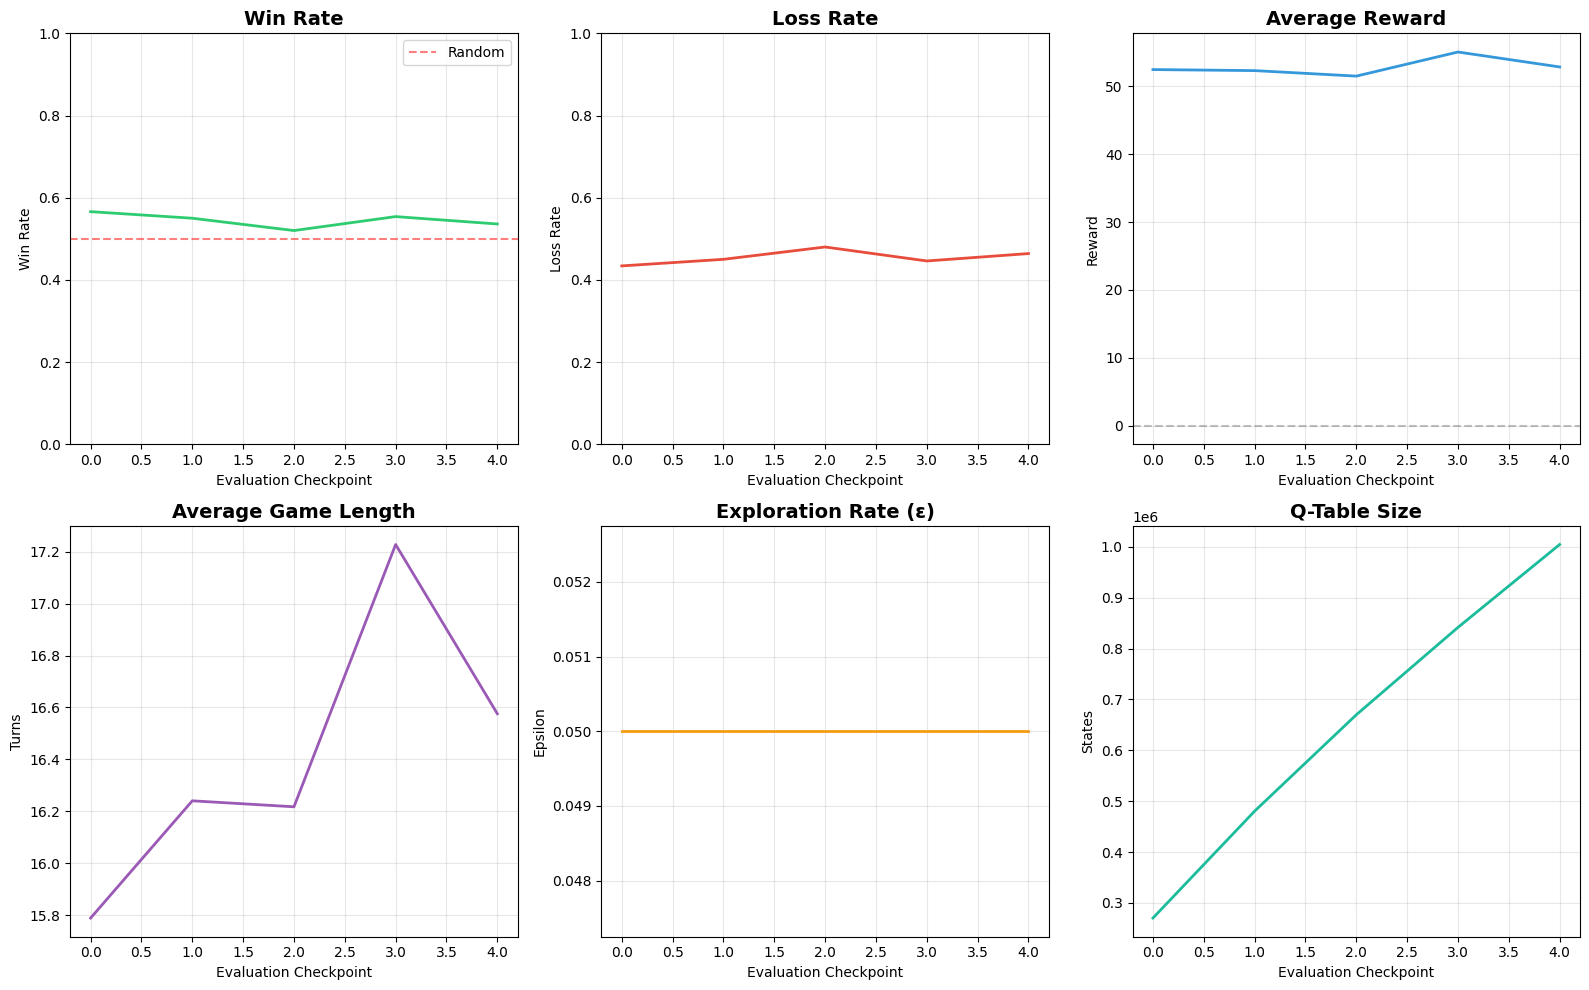

In [12]:
plot_training_results(stats, save_path='/kaggle/working/training_results.png')

## 💾 Save Model

In [13]:
import os

# Create directory
os.makedirs('/kaggle/working/model', exist_ok=True)

# Save Q-table
agent.save('/kaggle/working/model/qtable_improved.pkl')

# Save training stats
with open('/kaggle/working/model/training_stats.pkl', 'wb') as f:
    pickle.dump(stats, f)

# Save metadata
metadata = {
    'num_episodes': NUM_EPISODES,
    'observation_space': 'int16[57]',
    'observation_components': {
        '[0-9]': 'hand_counts',
        '[10-23]': 'table_card_one_hot',
        '[24-43]': 'legal_action_mask (20 actions)',
        '[44]': 'opponent_hand_size',
        '[45]': 'is_my_turn',
        '[46]': 'penalty_stack'
    },
    'alpha': agent.alpha,
    'gamma': agent.gamma,
    'q_table_size': len(agent.q_table),
    'total_updates': agent.total_updates,
    'final_win_rate': final_results['win_rate'],
    'final_avg_reward': final_results['avg_reward'],
    'action_space_size': 20
}

with open('/kaggle/working/model/metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)

print("=" * 80)
print("MODEL SAVED")
print("=" * 80)
print("Files:")
print("  ✓ qtable_improved.pkl")
print("  ✓ training_stats.pkl")
print("  ✓ metadata.pkl")
print("  ✓ training_results.png")
print("=" * 80)

MODEL SAVED
Files:
  ✓ qtable_improved.pkl
  ✓ training_stats.pkl
  ✓ metadata.pkl
  ✓ training_results.png


In [14]:
# Convert Q-table from pickle (slow, ~70s to load) to numpy npz (fast, ~2s to load)
# This fixes the XMPP keepalive starvation issue in the multi-agent system.
import numpy as np

q_dict = dict(agent.q_table)
keys = np.array(list(q_dict.keys()), dtype=np.int16)      # shape: (N, 62)
values = np.array(list(q_dict.values()), dtype=np.float32) # shape: (N, 25)

np.savez_compressed(
    '/kaggle/working/model/qtable_improved.npz',
    keys=keys,
    values=values
)

print(f'Saved {len(keys):,} states to qtable_improved.npz')
print(f'keys shape:   {keys.shape}')
print(f'values shape: {values.shape}')


Saved 1,074,485 states to qtable_improved.npz
keys shape:   (1074485, 62)
values shape: (1074485, 25)
